# Preprocess

## 1. Load data

In [1]:
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

cnt_file = r"D:\bcmi\exp\eeg_cnt_file\leixiaoting_20210324.cnt"

EOG_channels = ['VEO', 'HEO']
unused_channels = ['M1', 'M2']

raw = mne.io.read_raw_cnt(cnt_file, eog=EOG_channels)
raw.info['bads'].extend(EOG_channels)
raw.info['bads'].extend(unused_channels)

<ipython-input-1-b7b92f218379>:12: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_file, eog=EOG_channels)


In [ ]:
raw.info

In [ ]:
# M1, M2, VEO, HEO
raw.info['ch_names']

In [ ]:
# number of time points
raw.n_times

In [ ]:
raw.ch_names

## 2. Filtering
No occurence of AC power line interference.

In [2]:
raw.load_data()
raw_bandpass = raw.copy().filter(l_freq=1, h_freq=75)

raw_delta = raw_bandpass.copy().filter(l_freq=1, h_freq=4)
raw_theta = raw_bandpass.copy().filter(l_freq=4, h_freq=8)
raw_alpha = raw_bandpass.copy().filter(l_freq=8, h_freq=14)
raw_beta = raw_bandpass.copy().filter(l_freq=14, h_freq=31)
raw_gamma = raw_bandpass.copy().filter(l_freq=31, h_freq=50)

Reading 0 ... 2748079  =      0.000 ...  2748.079 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 75 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 75.00 Hz
- Upper transition bandwidth: 18.75 Hz (-6 dB cutoff frequency: 84.38 Hz)
- Filter length: 3301 samples (3.301 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 H

## 3. Mark bad channels

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

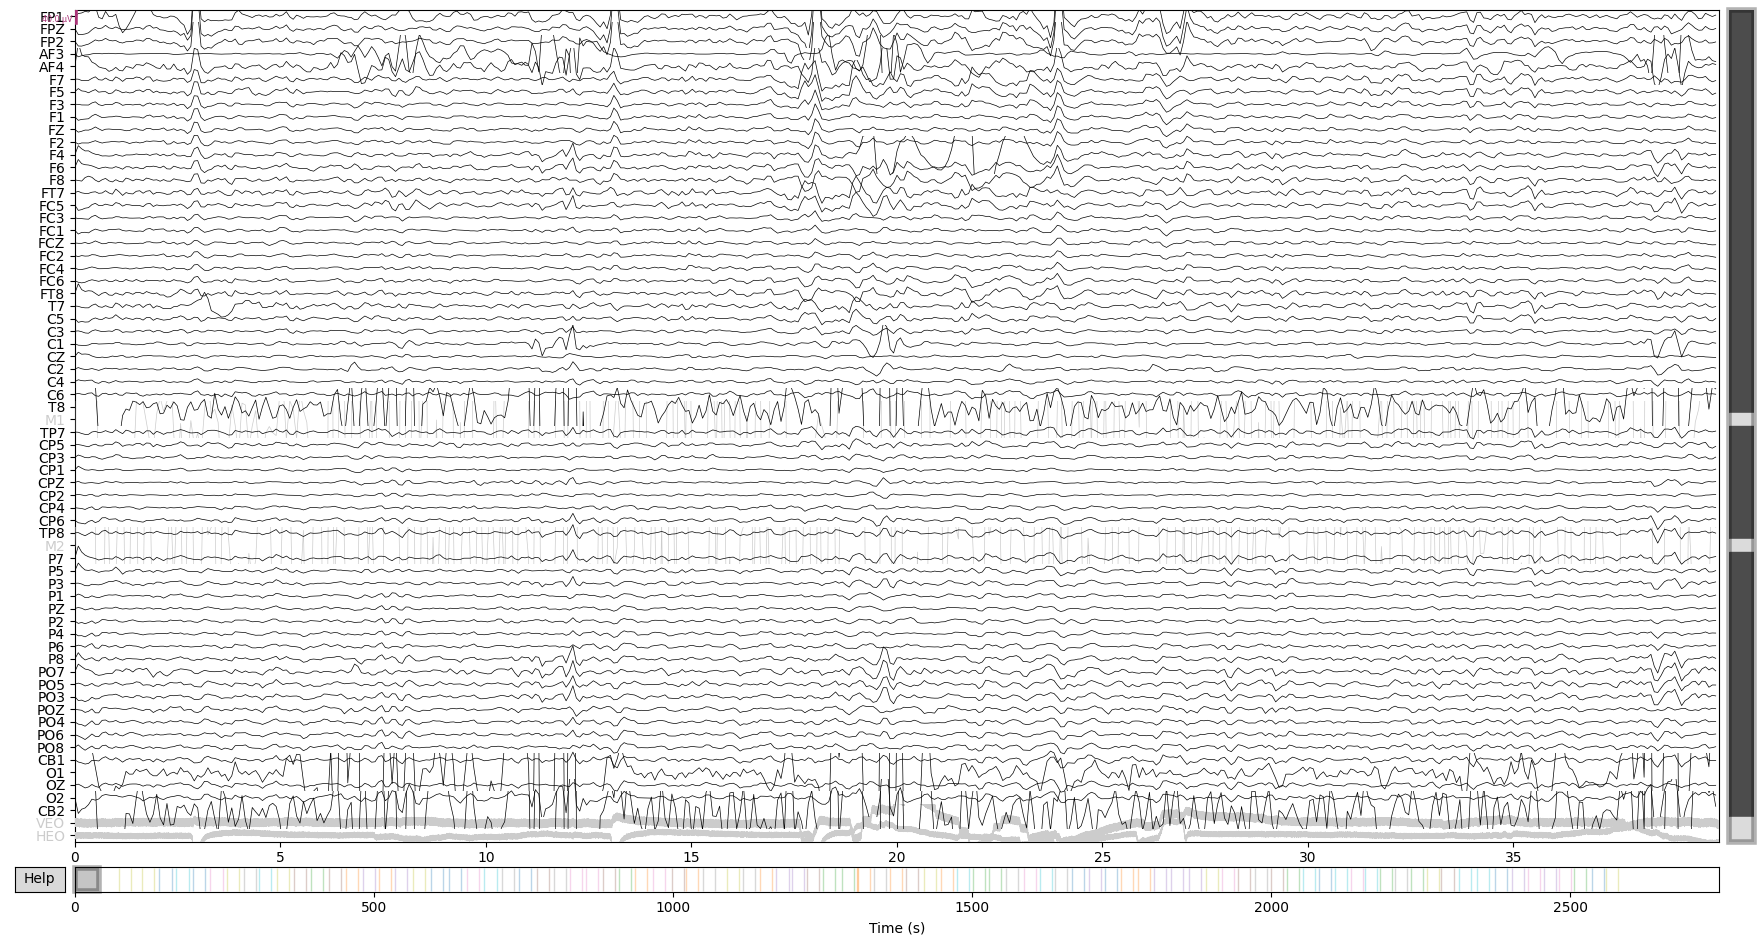

In [6]:
raw_delta.plot(duration=40, n_channels=66)

In [ ]:
bad_channels = ['O1', 'O2', 'OZ', 'T8', 'CB2']
raw_bandpass.info['bads'].extend(bad_channels)
# the plot after bandpass is much better
fig1 = raw_bandpass.plot(duration=40, n_channels=66)

In [ ]:
raw_bandpass.info

## 4. Set average reference ???

In [ ]:
raw_bandpass.set_eeg_reference(ref_channels='average')
fig2 = raw_bandpass.plot(duration=40, n_channels=66)

## 5. Remove artifacts with ICA
### 5.1 Visualize EOG artifact

In [ ]:
from mne.preprocessing import create_eog_epochs

eog_evoked = create_eog_epochs(raw_bandpass, ch_name=EOG_channels).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

### 5.2 Visualize ECG artifact

In [ ]:
from mne.preprocessing import create_ecg_epochs

ecg_evoked = create_ecg_epochs(raw_bandpass).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

### 5.3 ICA
Decompose

In [ ]:
from mne.preprocessing import ICA

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(raw_bandpass)

# plot the unfiltered raw file
ica.plot_sources(raw)

Exclude artifact components.

In [ ]:
ica.exclude = [0, 1]  # indices chosen based on plots above

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw_bandpass = raw_bandpass.copy()
ica.apply(reconst_raw_bandpass)

raw_bandpass.plot(n_channels=66)
reconst_raw_bandpass.plot(n_channels=66)
del reconst_raw_bandpass

## 6. Extract trigger events && Epoching

In [7]:
events, event_id = mne.events_from_annotations(raw_bandpass)

Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90']


In [ ]:
type(events), type(event_id)

In [ ]:
# the trigger number represents image number
# check psychopy code
event_id.keys()

In [ ]:
len(event_id.keys())

In [ ]:
event_id['1'], type(event_id['1'])

In [8]:
events.shape

(180, 3)

In [9]:
# (sample number, _, event code)
events[:10]

array([[ 74216,      0,     17],
       [ 94302,      0,     17],
       [112709,      0,     71],
       [132911,      0,     71],
       [141452,      0,     37],
       [161655,      0,     37],
       [169843,      0,     72],
       [189995,      0,     72],
       [196825,      0,     10],
       [216897,      0,     10]])

In [ ]:
# process labels
labels = []

In [ ]:
# For this subject
# (number of images, 6(1 total+5 frequency bands), number of channels, sample numbers)
# (90, 6, 62, 20000) 20s/image

for trigger in range(0, 180, 2):
    

In [ ]:
epochs = mne.Epochs(raw_bandpass, events, tmin=-0.3, tmax=0.7)

In [ ]:
len(epochs)

In [ ]:
useful_channels = raw.ch_names[:]

for ch in unused_channels:
    useful_channels.remove(ch)

for ch in EOG_channels:
    useful_channels.remove(ch)

image1_arr = epochs.get_data(picks=useful_channels, item='1')
image1_arr.shape

## 8. Output to .npy